In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from piston import DMDPiston

from dmdholo.fields_propagation.fourier_filter import fourier_filter
from dmdholo.holograms.dmd_holograms import parallel_lee,  orthogonal_lee, holo_SP, holo_Haskell
from dmdholo.holograms.generate_LUT import generate_lut
from dmdholo.plotting.plot_funs import colorize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(-0.5, 1023.5, 1023.5, -0.5)

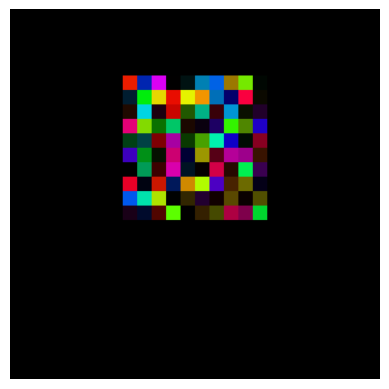

In [5]:
n = 10
dmd = DMDPiston(n, roi_size=400)
dmd.generate_fields(n, rand_amp=True, rand_phi=True)

target_field = np.copy(dmd.field_matrix)
target_field /= np.max(np.abs(target_field))

plt.imshow(colorize(target_field))
plt.gca().axis('off')

In [6]:
px = 4
nuvec = np.array((1/px,1/px**2)) 
SA_filter = 1.0*np.linalg.norm(nuvec)/6
f_val, px_comb, lut = generate_lut('sp', px)

In [9]:
n = 10
n_fields = 100
dmd = DMDPiston(n, roi_size=400)

target_fields = []
holos = []

for i in range(n_fields):
    dmd.generate_fields(n, rand_amp=True, rand_phi=True)
    target_field = np.copy(dmd.field_matrix)
    target_field /= np.max(np.abs(target_field))

    holo = holo_SP(target_field, lut, px_comb)

    target_fields.append(target_field)
    holos.append(holo)

(-0.5, 1023.5, 1023.5, -0.5)

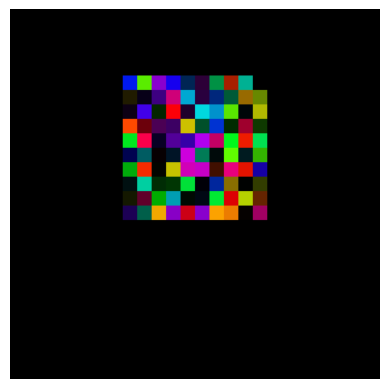

In [12]:
plt.imshow(colorize(target_fields[np.random.randint(n_fields)]))
plt.gca().axis('off')

In [52]:
shaped_field, ft_holo = fourier_filter(holo, nuvec, SA_filter, get_ft=True)
ft_holo_int = np.square(np.abs(ft_holo))
ft_holo_log = 10 * np.log10(ft_holo_int)

sh = np.array(ft_holo_log).shape
ap_loc = nuvec
ap_rad = SA_filter

err_amp = np.abs(shaped_field) - np.abs(target_field)
err_amp_norm = np.abs(shaped_field) / np.max(np.abs(shaped_field)) - np.abs(target_field) / np.max(np.abs(target_field))
err_phi = np.angle(np.exp(1j * (np.angle(shaped_field) - np.angle(target_field))))

C:\Users\saucourt\AppData\Local\Temp\ipykernel_28532\881014059.py:3: RuntimeWarning: divide by zero encountered in log10
  ft_holo_log = 10 * np.log10(ft_holo_int)


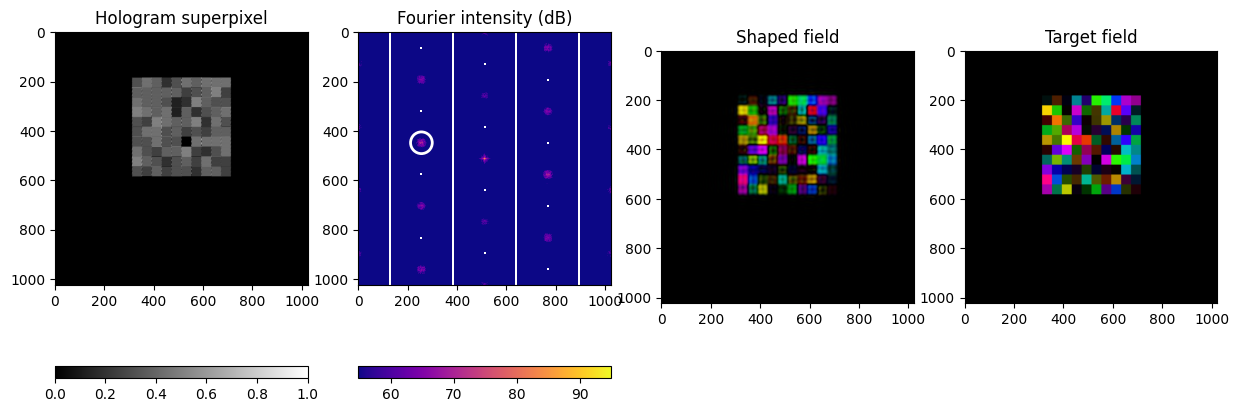

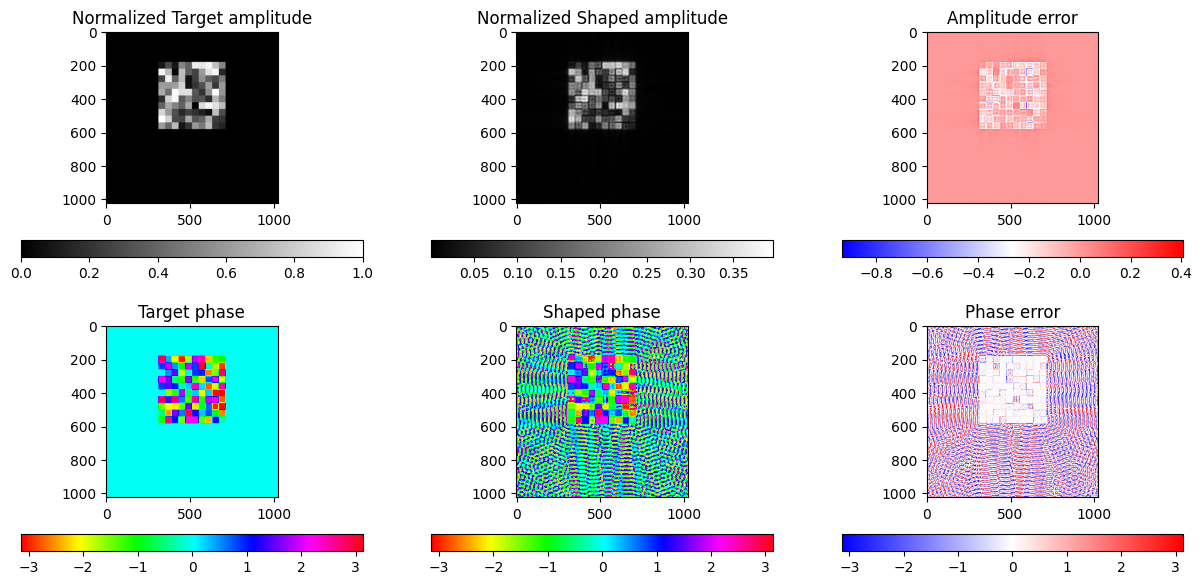

In [53]:
fig = plt.figure(figsize=(15, 7))

plt.subplot(1, 4, 1)
plt.imshow(holo, cmap='gray')
plt.title('Hologram superpixel')
plt.colorbar(location = 'bottom')

plt.subplot(1, 4, 2)
ax = plt.gca()
plt.imshow(ft_holo_log, cmap='plasma', vmax=np.max(ft_holo_log), vmin=np.max(ft_holo_log)-40)
ax.add_patch(
    Ellipse(
        np.array(sh)/2-ap_loc*np.array(sh), 
        width=2*ap_rad*sh[0],
        height=2*ap_rad*sh[1],
        edgecolor='white',
        facecolor='none',
        linewidth=2,
    )
)
plt.title('Fourier intensity (dB)')
plt.colorbar(location = 'bottom')

plt.subplot(1, 4, 3)
plt.imshow(colorize(shaped_field))
plt.title('Shaped field')

plt.subplot(1, 4, 4)
plt.imshow(colorize(target_field))
plt.title('Target field')

plt.show()


fig = plt.figure(figsize=(15, 7))

plt.subplot(2, 3, 1)
plt.imshow(np.abs(target_field), cmap='gray')
plt.title('Normalized Target amplitude')
plt.colorbar(location = 'bottom')

plt.subplot(2, 3, 2)
plt.imshow(np.abs(shaped_field), cmap='gray')
plt.title('Normalized Shaped amplitude')
plt.colorbar(location = 'bottom')

plt.subplot(2, 3, 3)
plt.imshow(err_amp_norm, cmap='bwr')
plt.title('Amplitude error')
plt.colorbar(location = 'bottom')

plt.subplot(2, 3, 4)
plt.imshow(np.angle(target_field), cmap='hsv')
plt.title('Target phase')
plt.colorbar(location = 'bottom')

plt.subplot(2, 3, 5)
plt.imshow(np.angle(shaped_field), cmap='hsv')
plt.title('Shaped phase')
plt.colorbar(location = 'bottom')

plt.subplot(2, 3, 6)
plt.imshow(err_phi, cmap='bwr')
plt.title('Phase error')
plt.colorbar(location = 'bottom')


plt.show()

In [13]:
import numpy as np
from ALP4 import *
import time

In [14]:
# Load the Vialux .dll
DMD = ALP4(version = '4.3', libDir=r"C:\Program Files\ALP-4.3\ALP-4.3 API")
# Initialize the device
DMD.Initialize()

Loading library: C:\Program Files\ALP-4.3\ALP-4.3 API/x64/alp4395.dll
DMD found, resolution = 1024 x 768.


In [45]:
crop = (holos[0].shape[0] - DMD.nSizeY) // 2
cropped_holos = np.array([np.roll(np.roll(holo[crop:-crop, :], shift=np.random.randint(1000), axis=0), shift=np.random.randint(1000), axis=1) for holo in holos])

In [70]:
bitDepth = 1
seq = cropped_holos * (2**8-1)

# Allocate the onboard memory for the image sequence
DMD.SeqAlloc(nbImg = seq.shape[0], bitDepth = bitDepth)

# Send the image sequence as a 1D list/array/numpy array
DMD.SeqPut(imgData = seq)

# Set image rate to 50 Hz
# DMD.SetTiming(pictureTime = 20000)
DMD.SetTiming(pictureTime = int(1 / 15000 * 1e6))

# Run the sequence in an infinite loop
DMD.Run()

# time.sleep(1)

In [37]:
1/ 50 

0.02

In [71]:
# Stop the sequence display
DMD.Halt()

In [72]:
# Free the sequence from the onboard memory
DMD.FreeSeq()
# De-allocate the device
DMD.Free()